In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import rioxarray as rxr
from pyproj import Transformer

In [2]:
data2 = xr.open_dataset("../../../../../../nobackup/users/buurmans/datatest.nc", decode_coords = "all")

In [3]:
# data2["lon"].values
data2

<xarray.Dataset>
Dimensions:            (time: 24, y: 789, x: 789)
Coordinates:
  * time               (time) datetime64[ns] 2015-09-25 ... 2015-09-25T23:00:00
  * y                  (y) float32 0.0 2.5e+03 5e+03 ... 1.968e+06 1.97e+06
  * x                  (x) float32 0.0 2.5e+03 5e+03 ... 1.968e+06 1.97e+06
    lon                (y, x) float32 ...
    lat                (y, x) float32 ...
    Lambert_Conformal  |S1 ...
    height             float32 ...
Data variables:
    z0                 (time, y, x) float32 ...
Attributes: (12/17)
    Conventions:                CF-1.4
    institute_id:               KNMI
    model_id:                   harmonie-40h1.2.tg2
    domain:                     NETHERLANDS
    driving_model_id:           ERA5
    creation_date:              Wed Apr  4 08:07:56 2018
    ...                         ...
    institution:                Royal Netherlands Meteorological Institute, D...
    data_contact:               Bert van Ulft, R&D Weather & Climate Models, ...
    history:                    Thu Feb 14 12:16:12 2019: ncrcat -A midnight_...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...
    nco_openmp_thread_number:   1
    history_of_appended_files:  Thu Feb 14 12:16:12 2019: Appended file midni...

In [4]:
def wrap_lon(ds):
    
    # method to 'wrap' longitudes from (0,360) to (-180,180) & sort into ascending order
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

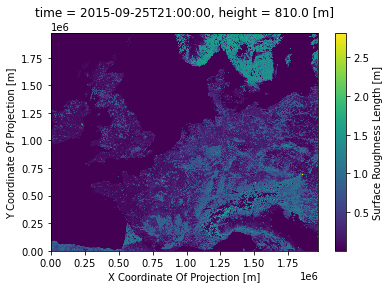

In [5]:
Z0_20 = data2.isel(time = 21)
Z0_20["z0"].plot(x="x", y="y")

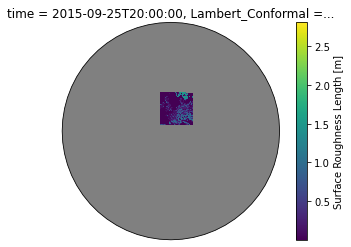

In [4]:
t20 = data2.isel(time = 20)
p = t20["z0"].plot(subplot_kws = dict(projection = ccrs.Orthographic(0,40), facecolor = 'gray'), x="lon", y="lat", transform = ccrs.PlateCarree())
p.axes.set_global()


In [7]:
era5data = xr.open_dataset("../../../../../../nobackup/users/buurmans/era5data2mt.nc")

In [8]:
era5data = wrap_lon(era5data)

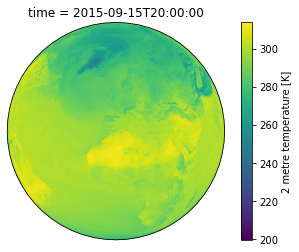

In [9]:
t20 = era5data.isel(time = 20)
p = t20["t2m"].plot(subplot_kws = dict(projection = ccrs.Orthographic(0,35), facecolor = 'gray'), transform = ccrs.PlateCarree())
p.axes.set_global()

In [10]:
data2 = data2.rename_vars({"z0": "t2m"})

In [11]:
era5data

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 24)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * time       (time) datetime64[ns] 2015-09-15 ... 2015-09-15T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-16 13:08:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [40]:
data2

<xarray.Dataset>
Dimensions:            (time: 24, y: 789, x: 789)
Coordinates:
  * time               (time) datetime64[ns] 2015-09-25 ... 2015-09-25T23:00:00
  * y                  (y) float32 0.0 2.5e+03 5e+03 ... 1.968e+06 1.97e+06
  * x                  (x) float32 0.0 2.5e+03 5e+03 ... 1.968e+06 1.97e+06
    lon                (y, x) float64 2.307 2.341 2.375 ... 40.51 40.55 40.59
    lat                (y, x) float64 49.29 49.29 49.29 ... 62.85 62.84 62.83
    height             float32 ...
    Lambert_Conformal  int64 0
Data variables:
    z0                 (time, y, x) float32 0.4783 0.635 ... 0.7305 0.4866
Attributes: (12/18)
    Conventions:                CF-1.4
    institute_id:               KNMI
    model_id:                   harmonie-40h1.2.tg2
    domain:                     NETHERLANDS
    driving_model_id:           ERA5
    creation_date:              Wed Apr  4 08:07:56 2018
    ...                         ...
    data_contact:               Bert van Ulft, R&D Weather & Climate Models, ...
    history:                    Thu Feb 14 12:16:12 2019: ncrcat -A midnight_...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...
    nco_openmp_thread_number:   1
    history_of_appended_files:  Thu Feb 14 12:16:12 2019: Appended file midni...
    crs:                        +init=epsg:4326

In [66]:
# Convert the DOWA data to long/lat coordinates
# Make a temporary copy
tempdata = data2.copy()
tempdata['lon'] = tempdata['lon'].sel(x=0).drop('x')
tempdata['lat'] = tempdata['lat'].sel(y=0).drop('y').sortby("lat", ascending = False)
tempdata = tempdata.set_index(x = "lat", y = "lon")
tempdata = tempdata.rename({"x":"latitude", "y":"longitude"})
tempdata


<xarray.Dataset>
Dimensions:            (time: 24, longitude: 789, latitude: 789)
Coordinates:
  * time               (time) datetime64[ns] 2015-09-25 ... 2015-09-25T23:00:00
  * longitude          (longitude) float32 -7.89 -7.893 -7.897 ... -11.76 -11.77
  * latitude           (latitude) float32 42.93 42.94 42.94 ... 41.97 41.96
    height             float32 ...
Data variables:
    Lambert_Conformal  |S1 ...
    t2m                (time, longitude, latitude) float32 ...
Attributes: (12/17)
    Conventions:                CF-1.4
    institute_id:               KNMI
    model_id:                   harmonie-40h1.2.tg2
    domain:                     NETHERLANDS
    driving_model_id:           ERA5
    creation_date:              Wed Apr  4 08:07:56 2018
    ...                         ...
    institution:                Royal Netherlands Meteorological Institute, D...
    data_contact:               Bert van Ulft, R&D Weather & Climate Models, ...
    history:                    Thu Feb 14 12:16:12 2019: ncrcat -A midnight_...
    NCO:                        netCDF Operators version 4.7.4 (http://nco.sf...
    nco_openmp_thread_number:   1
    history_of_appended_files:  Thu Feb 14 12:16:12 2019: Appended file midni...

In [67]:
# ROWS = LATITUDE, COLUMNS = LONGITUDE
t20_era = era5data.isel(time = 20)
t20_era = pd.DataFrame(t20_era["t2m"])
t20_era.columns = era5data.longitude
lat = era5data.latitude.to_numpy()
lat = [str(x) for x in lat]
t20_era.index = lat

In [96]:
t20_era

,-180.00,-179.75,-179.50,-179.25,-179.00,-178.75,-178.50,-178.25,-178.00,-177.75,...,177.50,177.75,178.00,178.25,178.50,178.75,179.00,179.25,179.50,179.75
-90.0,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438,...,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438,216.648438
-89.75,215.866745,215.868591,215.868591,215.870453,215.870453,215.872299,215.872299,215.874146,215.874146,215.874146,...,215.859360,215.859360,215.861206,215.861206,215.863052,215.863052,215.863052,215.864899,215.864899,215.866745
-89.5,215.290192,215.292038,215.293884,215.295731,215.299423,215.301270,215.303131,215.304977,215.306824,215.308670,...,215.273560,215.273560,215.275406,215.277252,215.279099,215.280945,215.282791,215.284637,215.286499,215.288345
-89.25,214.608292,214.610138,214.613831,214.615692,214.615692,214.617538,214.617538,214.619385,214.619385,214.621231,...,214.582428,214.586121,214.587967,214.589813,214.593506,214.595367,214.597198,214.600906,214.602753,214.604599
-89.0,213.935638,213.935638,213.935638,213.935638,213.935638,213.935638,213.935638,213.935638,213.935638,213.935638,...,213.919006,213.920853,213.920853,213.922699,213.926392,213.928253,213.928253,213.930099,213.931946,213.933792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89.0,263.920898,263.920898,263.920898,263.920898,263.920898,263.920898,263.920898,263.919067,263.919067,263.919067,...,263.902435,263.906128,263.907959,263.909821,263.911652,263.913513,263.915375,263.917206,263.919067,263.920898
89.25,263.285217,263.285217,263.285217,263.285217,263.285217,263.285217,263.285217,263.285217,263.285217,263.285217,...,263.264893,263.266724,263.268585,263.272278,263.275970,263.277832,263.279663,263.283356,263.285217,263.285217
89.5,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077,...,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077,262.679077
89.75,262.612549,262.612549,262.612549,262.612549,262.612549,262.612549,262.612549,262.612549,262.612549,262.612549,...,262.614410,262.612549,262.612549,262.612549,262.612549,262.612549,262.612549,262.612549,262.612549,262.612549


In [149]:
# ROWS = LATITUDE, COLUMNS = LONGITUDE (Latitude, longitude)
t20_dowa = data2.isel(time = 20)
t20_dowa = pd.DataFrame(t20_dowa["t2m"])
t20_dowa.columns = data2.longitude
lat = tempdata.latitude.to_numpy()
lat = [str(x) for x in lat]
t20_dowa.index = lat
print(t20_dowa.shape)

(789, 789)


In [69]:
def convert_to_sparse_pandas(df, exclude_columns=[]):
    """
    Converts columns of a data frame into SparseArrays and returns the data frame with transformed columns.
    Use exclude_columns to specify columns to be excluded from transformation.
    :param df: pandas data frame
    :param exclude_columns: list
        Columns not be converted to sparse
    :return: pandas data frame
    """
    df = df.copy()
    exclude_columns = set(exclude_columns)

    for (columnName, columnData) in df.items():
        if columnName in exclude_columns:
            continue
        df[columnName] = pd.arrays.SparseArray(columnData.values, dtype='uint8')

    return df

In [70]:
sparse_era = convert_to_sparse_pandas(t20_era)
sparse_dowa = convert_to_sparse_pandas(t20_dowa)

In [71]:
print(sparse_era.shape)
print(sparse_dowa.shape)

(721, 1440)
(789, 789)


In [121]:
merge = sparse_era.join(sparse_dowa, how = "outer")
merge.index = pd.to_numeric(merge.index)
merge = merge.sort_index()
merge = merge.reindex(sorted(merge.columns), axis=1)
print(merge)

        -180.00  -179.75  -179.50  -179.25  -179.00  -178.75  -178.50  \
-90.00    216.0    216.0    216.0    216.0    216.0    216.0    216.0   
-89.75    215.0    215.0    215.0    215.0    215.0    215.0    215.0   
-89.50    215.0    215.0    215.0    215.0    215.0    215.0    215.0   
-89.25    214.0    214.0    214.0    214.0    214.0    214.0    214.0   
-89.00    213.0    213.0    213.0    213.0    213.0    213.0    213.0   
...         ...      ...      ...      ...      ...      ...      ...   
 89.00      7.0      7.0      7.0      7.0      7.0      7.0      7.0   
 89.25      7.0      7.0      7.0      7.0      7.0      7.0      7.0   
 89.50      6.0      6.0      6.0      6.0      6.0      6.0      6.0   
 89.75      6.0      6.0      6.0      6.0      6.0      6.0      6.0   
 90.00      6.0      6.0      6.0      6.0      6.0      6.0      6.0   

        -178.25  -178.00  -177.75  ...   177.50   177.75   178.00   178.25  \
-90.00    216.0    216.0    216.0  ...    216

In [122]:
lon = merge.columns
lat = merge.index
xmerge = xr.Dataset(
    data_vars=dict(
        t2m = (["lat", "lon"], merge),
    ),
#     dims=["lat", "lon"],
    coords=dict(
        lon=(["lon"], lon),
        lat=(["lat"], lat),
    ),
    attrs=dict(
        description="Merged dataset",
    ),
)

In [123]:
xmerge["t2m"]

<xarray.DataArray 't2m' (lat: 1510, lon: 2229)>
array([[216., 216., 216., ..., 216., 216., 216.],
       [215., 215., 215., ..., 215., 215., 215.],
       [215., 215., 215., ..., 215., 215., 215.],
       ...,
       [  6.,   6.,   6., ...,   6.,   6.,   6.],
       [  6.,   6.,   6., ...,   6.,   6.,   6.],
       [  6.,   6.,   6., ...,   6.,   6.,   6.]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0

In [126]:
da_stacked = xmerge.stack(x=['lat','lon'])
da_stacked["t2m"][da_stacked["t2m"].notnull()==False]

<xarray.DataArray 't2m' (x: 1705029)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * x        (x) object MultiIndex
  * lat      (x) float64 -90.0 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * lon      (x) float64 -11.77 -11.76 -11.75 -11.74 ... -7.897 -7.893 -7.89

In [146]:
#  print(xmerge["t2m"].sortby("lon").sortby("lat"))
target_lon = tempdata.longitude
target_lat = tempdata.latitude
limarea_merge = xmerge["t2m"].sel(lon=target_lon, lat=target_lat, method="nearest")
limarea_merge

<xarray.DataArray 't2m' (latitude: 789, longitude: 789)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])
Coordinates:
    lon        (longitude) float64 -7.89 -7.893 -7.897 ... -11.75 -11.76 -11.77
    lat        (latitude) float64 42.93 42.94 42.94 42.94 ... 41.97 41.97 41.96
  * longitude  (longitude) float32 -7.89 -7.893 -7.897 ... -11.75 -11.76 -11.77
    height     float32 810.0
  * latitude   (latitude) float32 42.93 42.94 42.94 42.94 ... 41.97 41.97 41.96

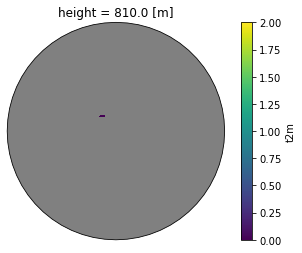

In [147]:
p = limarea_merge.sortby("lat").sortby("lon").plot(subplot_kws = dict(projection = ccrs.Orthographic(0,35), facecolor = 'gray'), transform = ccrs.PlateCarree())
p.axes.set_global()

/tmp/ipykernel_1001287/716284190.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(xmerge['lon'], xmerge['lat'], xmerge['t2m'])


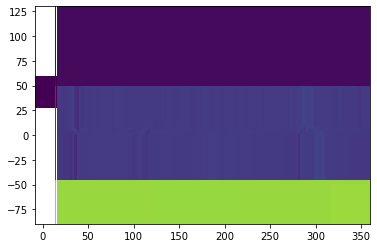

In [170]:
plt.pcolormesh(xmerge['lon'], xmerge['lat'], xmerge['t2m'])